##### Sequence Model

$$
P(x_1, \ldots, x_T) = P(x_1) \prod_{t=2}^{T} P(x_t \mid x_{t-1}, \ldots, x_1)
$$

##### Markov Models and n-grams

If we can condition only on the $\tau$ previous time steps, i.e., $x_{t-1}, \ldots, x_{t-\tau}$, rather than the entire sequence history $x_{t-1}, \ldots, x_{1}$, we say that the sequence satisfies a Markov condition, i.e., that the future is conditionally independent of the past, given the recent history. When $\tau = 1$, we say that the data is characterized by a first-order Markov model, and when $\tau=k$, we say that the data is characterized by a k-order Markov model. For when the first-order Markov condition holds ($\tau = 1$) the factorization of our joint probability becomes a product of probabilities of each word given the previous word:

$$
P(x_1, \ldots, x_T) = P(x_1) \prod_{t=2}^{T} P(x_t \mid x_{t-1})
$$


In [18]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

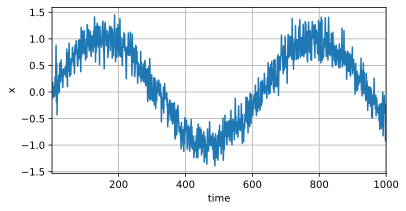

In [19]:
class Data(d2l.DataModule):
    def __init__(self, batch_size=16, T=1000, num_train=600, tau=4):
        self.save_hyperparameters()
        self.time = torch.arange(1, T + 1, dtype=torch.float32)
        self.x = torch.sin(0.01 * self.time) + torch.randn(T) * 0.2

data = Data()
d2l.plot(data.time, data.x, 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

In [52]:
# Simple & clear, but very efficient because of explicit loop

xx = torch.zeros(996, 4)
yy = torch.zeros(996, 1)

for i in range(996):
    xx[i] = data.x[i:i+4]
    yy[i] = data.x[i+4]

torch.allclose(xx, data.features)
torch.allclose(yy, data.labels)

True

In [53]:
# Creates 4 separate lists (since tau=4):

# features[0] = self.x[0:996] (elements 0-995)
# features[1] = self.x[1:997] (elements 1-996)
# features[2] = self.x[2:998] (elements 2-997)
# features[3] = self.x[3:999] (elements 3-998)
# torch.stack(features, 1) stacks them along dimension 1(column wise), 
# It takes the i-th element from each tensor and makes them a row:
# Row 0: [features[0][0], features[1][0], features[2][0], features[3][0]] = [x[0], x[1], x[2], x[3]]
# Row 1: [features[0][1], features[1][1], features[2][1], features[3][1]] = [x[1], x[2], x[3], x[4]]
# Row 2: [features[0][2], features[1][2], features[2][2], features[3][2]] = [x[2], x[3], x[4], x[5]]
# ...
# creating:
# [[x[0],   x[1],   x[2],   x[3]],
#  [x[1],   x[2],   x[3],   x[4]],
#  [x[2],   x[3],   x[4],   x[5]],
#  ...
#  [x[996], x[997], x[998], x[999]]]

@d2l.add_to_class(Data)
def get_dataloader(self, train):
    features = [self.x[i : self.T-self.tau+i] for i in range(self.tau)]
    print(f"features length: {len(features)}")
    # torch.stack() takes list of tensors and stacks them into a single tensor
    self.features = torch.stack(features, 1)
    self.labels = self.x[self.tau:].reshape((-1, 1))
    print(f"get_dataloader called - train={train}")
    print(f"self.features shape: {self.features.shape}, self.labels shape: {self.labels.shape}")
    i = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader([self.features, self.labels], train, i)

# Test the get_dataloader method directly to see the print output
print("Testing get_dataloader directly:")
train_loader = data.get_dataloader(train=True)
print("\nTesting validation dataloader:")
val_loader = data.get_dataloader(train=False)

Testing get_dataloader directly:
features length: 4
get_dataloader called - train=True
self.features shape: torch.Size([996, 4]), self.labels shape: torch.Size([996, 1])

Testing validation dataloader:
features length: 4
get_dataloader called - train=False
self.features shape: torch.Size([996, 4]), self.labels shape: torch.Size([996, 1])


In [54]:
# Understanding the dimension parameter in torch.stack()

print("=== torch.stack() with different dimensions ===")

a = torch.tensor([1, 2, 3])
b = torch.tensor([4, 5, 6]) 
c = torch.tensor([7, 8, 9])

tensors = [a, b, c]
print("torch.stack() input: List/tuple of tensors")
print(f"Input tensors:")
print(f"a = {a}")
print(f"b = {b}")  
print(f"c = {c}")

print(f"\n--- torch.stack(tensors, 0) -> Stack along dimension 0 (rows) ---")
stack_0 = torch.stack(tensors, 0)
print(f"Result shape: {stack_0.shape}")
print(f"Result:\n{stack_0}")

print(f"\n--- torch.stack(tensors, 1) -> Stack along dimension 1 (columns) ---")
stack_1 = torch.stack(tensors, 1)  
print(f"Result shape: {stack_1.shape}")
print(f"Result:\n{stack_1}")

print(f"\n=== Why we use dimension 1 for features ===")
print("features[0] = [x[0], x[1], x[2], x[3], x[4], x[5]]  <- time steps 0-5")
print("features[1] = [x[1], x[2], x[3], x[4], x[5], x[6]]  <- time steps 1-6") 
print("features[2] = [x[2], x[3], x[4], x[5], x[6], x[7]]  <- time steps 2-7")
print("features[3] = [x[3], x[4], x[5], x[6], x[7], x[8]]  <- time steps 3-8")
print("")
print("stack(features, 1) makes each ROW a sliding window:")
print("Row 0: [x[0], x[1], x[2], x[3]]  <- features from time 0,1,2,3")
print("Row 1: [x[1], x[2], x[3], x[4]]  <- features from time 1,2,3,4")
print("Row 2: [x[2], x[3], x[4], x[5]]  <- features from time 2,3,4,5")
print("...")
print("This creates (samples × time_steps) shape = (996, 4)")

=== torch.stack() with different dimensions ===
torch.stack() input: List/tuple of tensors
Input tensors:
a = tensor([1, 2, 3])
b = tensor([4, 5, 6])
c = tensor([7, 8, 9])

--- torch.stack(tensors, 0) -> Stack along dimension 0 (rows) ---
Result shape: torch.Size([3, 3])
Result:
tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]])

--- torch.stack(tensors, 1) -> Stack along dimension 1 (columns) ---
Result shape: torch.Size([3, 3])
Result:
tensor([[1, 4, 7],
        [2, 5, 8],
        [3, 6, 9]])

=== Why we use dimension 1 for features ===
features[0] = [x[0], x[1], x[2], x[3], x[4], x[5]]  <- time steps 0-5
features[1] = [x[1], x[2], x[3], x[4], x[5], x[6]]  <- time steps 1-6
features[2] = [x[2], x[3], x[4], x[5], x[6], x[7]]  <- time steps 2-7
features[3] = [x[3], x[4], x[5], x[6], x[7], x[8]]  <- time steps 3-8

stack(features, 1) makes each ROW a sliding window:
Row 0: [x[0], x[1], x[2], x[3]]  <- features from time 0,1,2,3
Row 1: [x[1], x[2], x[3], x[4]]  <- features from ti

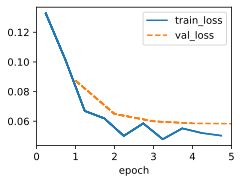

In [55]:
model = d2l.LinearRegression(lr=0.01)
trainer = d2l.Trainer(max_epochs=5)
trainer.fit(model, data)

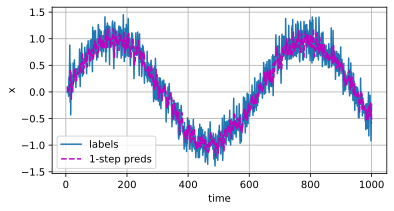

In [56]:
onestep_preds = model(data.features).detach().numpy()
d2l.plot(data.time[data.tau:], [data.labels, onestep_preds], 'time', 'x',
         legend=['labels', '1-step preds'], figsize=(6, 3))

In [47]:
data.num_train

600

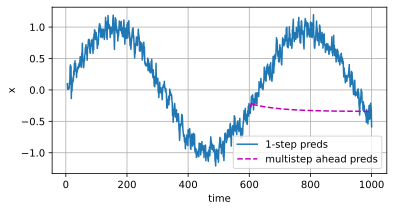

In [57]:
multistep_preds = torch.zeros(data.T)
multistep_preds[:] = data.x
for i in range(data.num_train + data.tau, data.T):
    multistep_preds[i] = model(
        multistep_preds[i - data.tau:i].reshape((1, -1)))
multistep_preds = multistep_preds.detach().numpy()

d2l.plot([data.time[data.tau:], data.time[data.num_train+data.tau:]],
         [onestep_preds, multistep_preds[data.num_train+data.tau:]], 'time',
         'x', legend=['1-step preds', 'multistep ahead preds'], figsize=(6, 3))

# It failed fail spectacularly

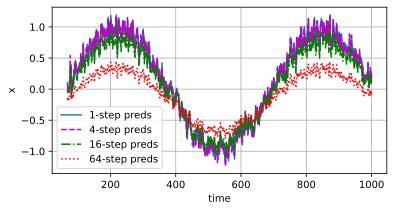

In [58]:
# Let’s take a closer look at the difficulties in k-step-ahead predictions by computing predictions on the entire sequence for k = 1,4,16,64.
def k_step_pred(k):
    features = []
    for i in range(data.tau):
        features.append(data.x[i : i+data.T-data.tau-k+1])
    # The (i+tau)-th element stores the (i+1)-step-ahead predictions
    for i in range(k):
        preds = model(torch.stack(features[i : i+data.tau], 1))
        features.append(preds.reshape(-1))
    return features[data.tau:]

steps = (1, 4, 16, 64)
preds = k_step_pred(steps[-1])
d2l.plot(data.time[data.tau+steps[-1]-1:],
         [preds[k - 1].detach().numpy() for k in steps], 'time', 'x',
         legend=[f'{k}-step preds' for k in steps], figsize=(6, 3))


==================Converting Raw Text into Sequence Data===================

In [60]:
import collections
import random
import re
import torch
from d2l import torch as d2l

In [63]:
class TimeMachine(d2l.DataModule): #@save
    """The Time Machine dataset."""
    def _download(self):
        fname = d2l.download(d2l.DATA_URL + 'timemachine.txt', self.root,
                             '090b5e7e70c295757f55df93cb0a180b9691891a')
        with open(fname) as f:
            return f.read()

data = TimeMachine()
raw_text = data._download()
raw_text[:100]

'The Time Machine, by H. G. Wells [1898]\n\n\n\n\nI\n\n\nThe Time Traveller (for so it will be convenient to '

In [64]:
@d2l.add_to_class(TimeMachine)  #@save
def _preprocess(self, text):
    # For simplicity, we ignore punctuation and capitalization
    # [^...] = Negation; + = One or more consecutive occurrences
    # '[^A-Za-z]+' = 'one or more characters that are NOT letters'
    return re.sub('[^A-Za-z]+', ' ', text).lower()

text = data._preprocess(raw_text)
text[:100]

'the time machine by h g wells i the time traveller for so it will be convenient to speak of him was '

In [68]:
@d2l.add_to_class(TimeMachine)  #@save
def _tokenize(self, text):
    return list(text)

tokens = data._tokenize(text)
','.join(tokens[:30])

't,h,e, ,t,i,m,e, ,m,a,c,h,i,n,e, ,b,y, ,h, ,g, ,w,e,l,l,s, '

In [69]:
class Vocab:  #@save
    """Vocabulary for text."""
    def __init__(self, tokens=[], min_freq=0, reserved_tokens=[]):
        # Flatten a 2D list if needed
        if tokens and isinstance(tokens[0], list):
            tokens = [token for line in tokens for token in line]
        # Count token frequencies
        counter = collections.Counter(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                  reverse=True)
        # The list of unique tokens
        self.idx_to_token = list(sorted(set(['<unk>'] + reserved_tokens + [
            token for token, freq in self.token_freqs if freq >= min_freq])))
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if hasattr(indices, '__len__') and len(indices) > 1:
            return [self.idx_to_token[int(index)] for index in indices]
        return self.idx_to_token[indices]

    @property
    def unk(self):  # Index for the unknown token
        return self.token_to_idx['<unk>']

In [70]:
vocab = Vocab(tokens)
indices = vocab[tokens[:10]]
print('indices:', indices)
print('words:', vocab.to_tokens(indices))

indices: [21, 9, 6, 0, 21, 10, 14, 6, 0, 14]
words: ['t', 'h', 'e', ' ', 't', 'i', 'm', 'e', ' ', 'm']


In [71]:
@d2l.add_to_class(TimeMachine)  #@save
def build(self, raw_text, vocab=None):
    tokens = self._tokenize(self._preprocess(raw_text))
    if vocab is None: vocab = Vocab(tokens)
    corpus = [vocab[token] for token in tokens]
    return corpus, vocab

corpus, vocab = data.build(raw_text)
len(corpus), len(vocab)

(173428, 28)

In [73]:
vocab.idx_to_token

[' ',
 '<unk>',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [74]:
words = text.split()
vocab = Vocab(words)
vocab.token_freqs[:10]

# ten most frequent words are not all that descriptive: stop words

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440)]

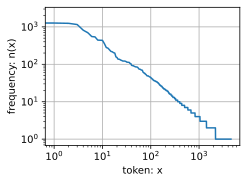

In [75]:
freqs = [freq for token, freq in vocab.token_freqs]
d2l.plot(freqs, xlabel='token: x', ylabel='frequency: n(x)',
         xscale='log', yscale='log')

# word frequency decays quickly. The 10-th most frequent word is less than 1/5 as common as the most popular. Word frequency tends to follow a
# power law distribution (specifically the Zipfian) as we go down the ranks.

In [77]:
bigram_tokens = ['--'.join(pair) for pair in zip(words[:-1], words[1:])]
bigram_vocab = Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]
# Out of the ten most frequent word pairs, nine are composed of both stop words and only one is relevant to the actual book — "the time"

[('of--the', 309),
 ('in--the', 169),
 ('i--had', 130),
 ('i--was', 112),
 ('and--the', 109),
 ('the--time', 102),
 ('it--was', 99),
 ('to--the', 85),
 ('as--i', 78),
 ('of--a', 73)]

In [78]:
trigram_tokens = ['--'.join(triple) for triple in zip(
    words[:-2], words[1:-1], words[2:])]
trigram_vocab = Vocab(trigram_tokens)
trigram_vocab.token_freqs[:10]

[('the--time--traveller', 59),
 ('the--time--machine', 30),
 ('the--medical--man', 24),
 ('it--seemed--to', 16),
 ('it--was--a', 15),
 ('here--and--there', 15),
 ('seemed--to--me', 14),
 ('i--did--not', 14),
 ('i--saw--the', 13),
 ('i--began--to', 13)]

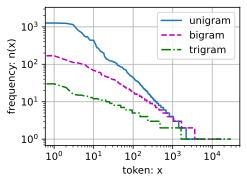

In [79]:
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]
d2l.plot([freqs, bigram_freqs, trigram_freqs], xlabel='token: x',
         ylabel='frequency: n(x)', xscale='log', yscale='log',
         legend=['unigram', 'bigram', 'trigram'])

In [ ]:
# Text is among the most common forms of sequence data encountered in deep learning. 
# Common choices for what constitutes a token are characters, words, and word pieces. To preprocess text, we usually 
# (i) split text into tokens; 
# (ii) build a vocabulary to map token strings to numerical indices;
# (iii) convert text data into token indices for models to manipulate. 
# In practice, the frequency of words tends to follow Zipf’s law. This is true not just for individual words (unigrams), but also for n-grams.

======================Language Models========================

In [81]:
import torch
from d2l import torch as d2l

In [83]:
@d2l.add_to_class(d2l.TimeMachine)  #@save
def __init__(self, batch_size, num_steps, num_train=10000, num_val=5000):
    super(d2l.TimeMachine, self).__init__()
    self.save_hyperparameters()
    corpus, self.vocab = self.build(self._download())
    array = torch.tensor([corpus[i:i+num_steps+1]
                        for i in range(len(corpus)-num_steps)])
    self.X, self.Y = array[:,:-1], array[:,1:]

In [84]:
@d2l.add_to_class(d2l.TimeMachine)  #@save
def get_dataloader(self, train):
    idx = slice(0, self.num_train) if train else slice(
        self.num_train, self.num_train + self.num_val)
    return self.get_tensorloader([self.X, self.Y], train, idx)

In [85]:
data = d2l.TimeMachine(batch_size=2, num_steps=10)
for X, Y in data.train_dataloader():
    print('X:', X, '\nY:', Y)
    break

X: tensor([[16,  0, 21,  9,  6,  0,  8, 19,  2, 23],
        [22,  0, 12, 15, 16, 24,  0, 16,  7,  0]]) 
Y: tensor([[ 0, 21,  9,  6,  0,  8, 19,  2, 23,  6],
        [ 0, 12, 15, 16, 24,  0, 16,  7,  0,  4]])


=================== Recurrent Neural Networks=====================

#####  latent variable model： 
$$
P(x_t | x_{t-1}, \dots, x_1) \approx P(x_t | h_{t-1})
$$
where $h_{t-1}$ is a hidden state that stores the sequence information up to time step $t-1$. In general, the hidden state at any time step t could be computed based on both the current input $x_t$ and the previous hidden state $h_{t-1}$: $h_t = f(x_t, h_{t-1})$

In [ ]:
import torch
from d2l import torch as d2l

##### 2-layer Neural Networks without hidden states: $H =  \phi(XW_{xh} + b_h)$, output layer: $O = \phi(HW_{hq} + b_q)$

##### 2-layer Recurrent Neural Network with hidden states: $H_t =  \phi(X_tW_{xh} + b_h + H_{t-1}W_{tt})$, output layer: $O_t = \phi(H_tW_{hq} + b_q)$

![img](Images/RNN_1.png)

In [87]:
X, W_xh = torch.randn(3, 1), torch.randn(1, 4)
H, W_hh = torch.randn(3, 4), torch.randn(4, 4)
torch.matmul(X, W_xh) + torch.matmul(H, W_hh)

tensor([[ 3.2792, -1.7686,  1.2301, -2.9375],
        [-3.2401, -0.5017, -2.5180,  2.1650],
        [-1.0118, -1.7905, -2.3342,  1.1386]])

In [88]:
torch.matmul(torch.cat((X, H), 1), torch.cat((W_xh, W_hh), 0))

tensor([[ 3.2792, -1.7686,  1.2301, -2.9375],
        [-3.2401, -0.5017, -2.5180,  2.1650],
        [-1.0118, -1.7905, -2.3342,  1.1386]])

=====================Recurrent Neural Network Implementation from Scratch=====================

In [89]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [90]:
class RNNScratch(d2l.Module):  #@save
    """The RNN model implemented from scratch."""
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.W_xh = nn.Parameter(
            torch.randn(num_inputs, num_hiddens) * sigma)
        self.W_hh = nn.Parameter(
            torch.randn(num_hiddens, num_hiddens) * sigma)
        self.b_h = nn.Parameter(torch.zeros(num_hiddens))

In [ ]:
@d2l.add_to_class(RNNScratch)  #@save
def forward(self, inputs, state=None):
    if state is None:
        # Initial state with shape: (batch_size, num_hiddens)
        state = torch.zeros((inputs.shape[1], self.num_hiddens), device=inputs.device)
    else:
        state, = state
    outputs = []
    for X in inputs:  
        # Shape of inputs: (num_steps, batch_size, num_inputs)
        # num_inputs: can means 27 if using char one-hot embedding, or embedding_dimension if using word embeddings
        state = torch.tanh(torch.matmul(X, self.W_xh) + torch.matmul(state, self.W_hh) + self.b_h)
        outputs.append(state)
    return outputs, state

In [92]:
batch_size, num_inputs, num_hiddens, num_steps = 2, 16, 32, 100
rnn = RNNScratch(num_inputs, num_hiddens)
X = torch.ones((num_steps, batch_size, num_inputs))
outputs, state = rnn(X)

In [93]:
def check_len(a, n):  #@save
    """Check the length of a list."""
    assert len(a) == n, f'list\'s length {len(a)} != expected length {n}'

def check_shape(a, shape):  #@save
    """Check the shape of a tensor."""
    assert a.shape == shape, \
            f'tensor\'s shape {a.shape} != expected shape {shape}'

check_len(outputs, num_steps)
check_shape(outputs[0], (batch_size, num_hiddens))
check_shape(state, (batch_size, num_hiddens))